# EDA - Heart Disease UCI

Ссылка на данные: https://www.kaggle.com/ronitf/heart-disease-uci

In [1]:
!cd $PROJECT_HOME

import os
from dataclasses import dataclass
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
from matplotlib import pyplot as plt
from kaggle.api.kaggle_api_extended import KaggleApi
from omegaconf import OmegaConf

%matplotlib inline

## Настройки датасета

In [3]:
conf = OmegaConf.structured({'data':
    OmegaConf.structured({
        'dataset': 'ronitf/heart-disease-uci',
        'url': 'https://www.kaggle.com/ronitf/heart-disease-uci',
        'data_dir': 'data/raw'
    })
})
OmegaConf.to_container(conf)

{'data': {'dataset': 'ronitf/heart-disease-uci',
  'url': 'https://www.kaggle.com/ronitf/heart-disease-uci',
  'data_dir': 'data/raw'}}

## Загрузка данных

In [4]:
api = KaggleApi()
api.authenticate()
api.dataset_download_files(conf.data.dataset,
                           path=conf.data.data_dir,
                           force=True,
                           unzip=True)
os.listdir(conf.data.data_dir)

['heart.csv']

In [5]:
conf.data.data_path = f'{conf.data.data_dir}/heart.csv'

In [6]:
df_raw = pd.read_csv(conf.data.data_path)
display(f'Raw data shape: {df_raw.shape}')
df_raw.head(3)

'Raw data shape: (303, 14)'

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


# Описание данных

- age
- sex
- chest pain type (4 values)
- resting blood pressure
- serum cholestoral in mg/dl
- fasting blood sugar > 120 mg/dl
- resting electrocardiographic results (values 0,1,2)
- maximum heart rate achieved
- exercise induced angina
- oldpeak = ST depression induced by exercise relative to rest
- the slope of the peak exercise ST segment
- number of major vessels (0-3) colored by flourosopy
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [7]:
df_meta = df_raw.describe(include='all').T \
    .join(pd.Series({c: df_raw[c].unique().shape[0] for c in df_raw.columns}, name='unique')) \
    .join(pd.Series(df_raw.dtypes, name='dtype'))
df_meta

,count,mean,std,min,25%,50%,75%,max,unique,dtype
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0,41,int64
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0,2,int64
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0,4,int64
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0,49,int64
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0,152,int64
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0,2,int64
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0,3,int64
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0,91,int64
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0,2,int64
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2,40,float64


### Пропуски в данных: отсутствуют

In [8]:
df_meta.index[df_meta['count'] < df_raw.shape[0]]

Index([], dtype='object')

### Повторы в данных: один повтор

In [9]:
df_raw[df_raw.duplicated()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


## Распределение целевой переменной:

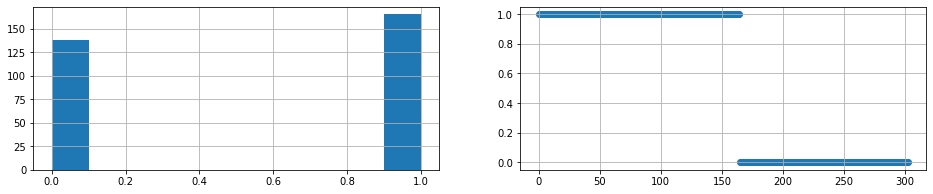

In [10]:
conf.feats = OmegaConf.create({})
conf.feats.target_col = 'target'

df_meta.loc[[conf.feats.target_col]]

plt.figure(figsize=(16,3))

plt.subplot(121)
df_raw['target'].hist()
plt.subplot(122)
plt.scatter(df_raw.index, df_raw['target'])
plt.grid()

plt.show()

## Распределение признаков и наличие выбросов:

'Feature distributions and outliers'

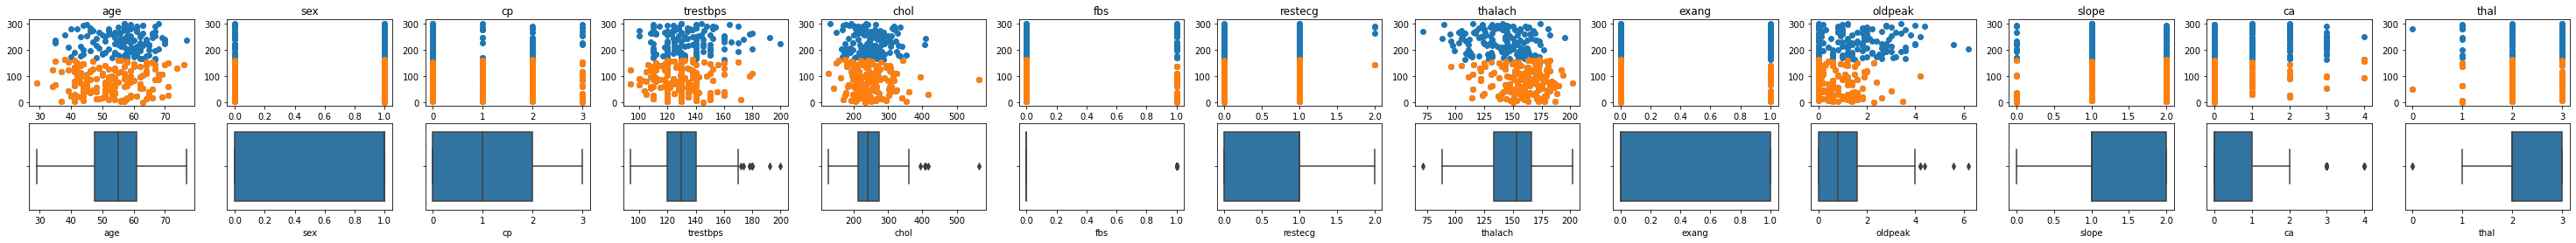

In [11]:
display('Feature distributions and outliers')

feats_count = df_raw.shape[1] - 1

plt.figure(figsize=(4*feats_count, 4))

for i, col in enumerate(df_raw):
    if col == conf.feats.target_col:
        continue
    plt.subplot(2, feats_count, i+1)
    if df_meta['dtype'][col].str.startswith('int64') and df_meta.loc[col, 'std'] < 2.0:
        df_raw[col].hist(label='all')
        df_raw[df_raw[conf.feats.target_col] == 1][col].hist(label='desease')
    else:
        plt.scatter(df_raw[col], df_raw[col].index, label='all')
        df = df_raw[df_raw[conf.feats.target_col] == 1]
        plt.scatter(df[col], df[col].index, label='desease')
    plt.title(col)
    
    plt.subplot(2, feats_count, feats_count+i+1)
    sns.boxplot(x=df_raw[col])

plt.show()

## Кореляции признаков:

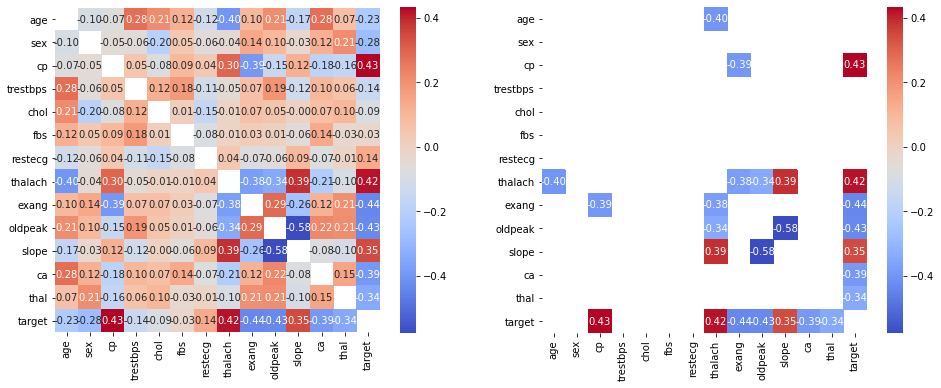

In [12]:
plt.figure(figsize=(16,6))

df_corr = df_raw.corr()
corr_mask = df_corr.abs() > 0.3

plt.subplot(121)
sns.heatmap(df_corr.replace(1.0, np.nan), annot = True, square=True, fmt='.2f',cmap= 'coolwarm')

plt.subplot(122)
sns.heatmap(df_corr[corr_mask].replace(1.0, np.nan), annot = True, fmt='.2f',cmap= 'coolwarm')

plt.show()

'Most correlated features:'

['age', 'cp', 'thalach', 'exang', 'oldpeak', 'slope', 'target']

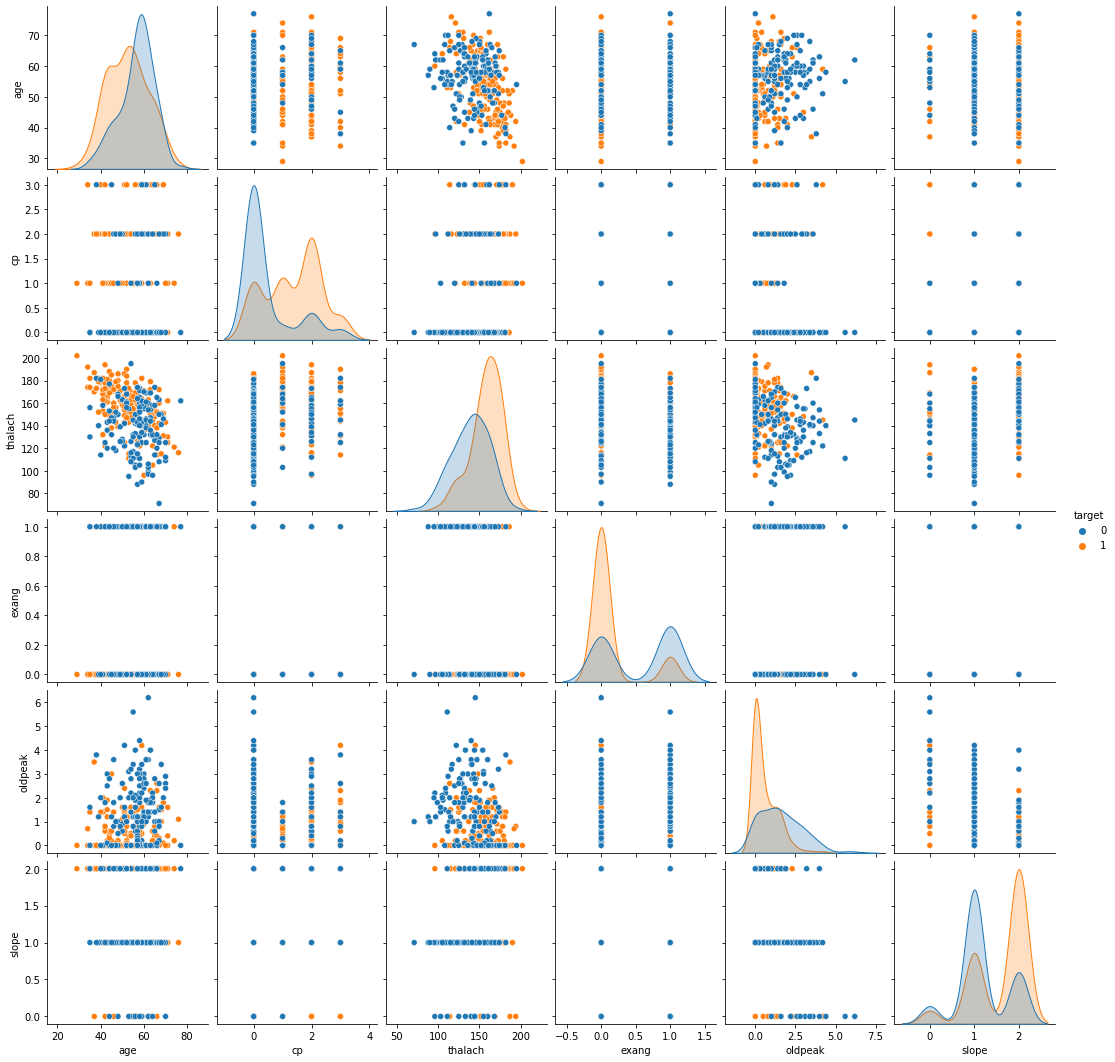

In [13]:
most_correlated_feats = df_corr[corr_mask] \
    .replace(1.0, np.nan) \
    .loc[lambda df: df.index[:-1], :] \
    .dropna(how='all', axis=1) \
    .columns.tolist()

display('Most correlated features:', most_correlated_feats)

sns.pairplot(df_raw[most_correlated_feats], hue=conf.feats.target_col)
plt.show()

Рассматриваемый датасет достаточно академичный и простой, для наглядного и качественного EDA-отчета используем pandas_profiling

In [15]:
df_raw.profile_report(title='Heart Disease UCI') \
    .to_file('reports/EDA-report.html')

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<a href="http:///tree/reports/EDA-report.html">View report</a>

На основе полученного отчета выделяем категориальные и числовые признаки

In [17]:
conf.feats.categorcal_feats = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
conf.feats.numerical_feats = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

display(f'Categirical feats: {conf.feats.categorcal_feats}')
display(f'Numerical feats: {conf.feats.numerical_feats}')

"Categirical feats: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']"

"Numerical feats: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']"

## Настройки датасета

In [19]:
!mkdir -p conf
with open('conf/data.yaml', 'w') as f:
    OmegaConf.save(config=conf, f=f)